# Identify the product category

**Problem Statement**  
The applications of Deep Neural Nets is on a roll. Whether it is healthcare, transportation, or retail, companies across all industries are excited about investing in building intelligent solutions. Meanwhile, let's hope human intelligence remains uncontested.

In this challenge, you will help one of the largest retailers in Germany improve their inventory-management process in its Food and Groceries business. The company is looking for intelligent solutions that can reduce the amount of human effort in its warehouse and retail outlets.

A solution such as a powerful image classifier can help the company track shelf inventory, categorize products, record product volume etc.

You are required to predict the category of each product.

The link to hackerearth competition is here [hackerearth-identify-the-objects](https://www.hackerearth.com/problem/machine-learning/identify-the-objects/).

# Data Preparation - Splitting Data for Keras ImageDataGenerator

This notebook is created from this Keras blog https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In the blog the author `@fchollet` used only a few training examples but here we will use the entire dataset. In this notebook, we are going to build a classifier for 25 different product images. We only have around 150 images per class, which is nowhere near enough data to train a model from scratch.

To start we will need to download and unzip the competition data from [hackerearth-identify-the-objects](https://www.hackerearth.com/problem/machine-learning/identify-the-objects/).

These are the following classes in the data set.

```
'beans', 'cake', 'candy', 'cereal', 'chips', 'chocolate', 'coffee', 'corn', 'fish', 'flour', 'honey', 'jam', 'juice', 'milk', 'nuts', 'oil', 'pasta', 'rice', 'soda', 'spices', 'sugar', 'tea', 'tomatosauce', 'vinegar', 'water'
```

First of all, we need to structure our training and validation datasets. We'll be using the `ImageDataGenerator` and `flow_from_directory()` functionality of `Keras`, so we need to create a directory structure where images of each class sits within its own sub-directory in the training and validation directories. So, we created the following directory structure for the `Keras ImageDataGenerator` to work. For the test data where we do not have any class to create sub directories but we still need to create a directory called `'unknown'` for the `Keras ImageDataGenerator` to work.

```
data/
    train/
        beans/
            train_1a.png
            ...
            train_1b.png
        cake/
            train_2a.png
            ...
            train_2b.png
        candy/
        ...
        water
            train_25a.png
            ...
            train_25b.png
    valid/
        beans/
            train_1a.png
            ...
            train_1b.png
        cake/
            train_2a.png
            ...
            train_2b.png
        candy/
        ...
        water
            train_25a.png
            ...
            train_25b.png
    test/
        unknown/
            train_1a.png
            ...
            train_25b.png
```

In [1]:
import pandas as pd
import numpy as np

import cv2
import skimage.io

import matplotlib.pyplot as plt
import seaborn as sns

import pathlib
from shutil import copyfile

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.options.display.max_columns = 30

In [3]:
seed = 23
np.random.seed(seed)

In [4]:
train_labels_df = pd.read_csv('data/train.csv')
test_labels_df = pd.read_csv('data/test.csv')

In [5]:
print ('The train data has {} images.'.format(train_labels_df.shape[0]))
print ('The test data has {} images.'.format(test_labels_df.shape[0]))

The train data has 3215 images.
The test data has 1732 images.


In [6]:
train_labels_df.head(3)

image_id  label
0  train_1a   rice
1  train_1b  candy
2  train_1c    jam

In [7]:
test_labels_df.head(3)

image_id
0  test_1000a
1  test_1000b
2  test_1000c

In [8]:
# unique label count
print ('The train data has {} unique labels.'.format(train_labels_df['label'].nunique()))

The train data has 25 unique labels.


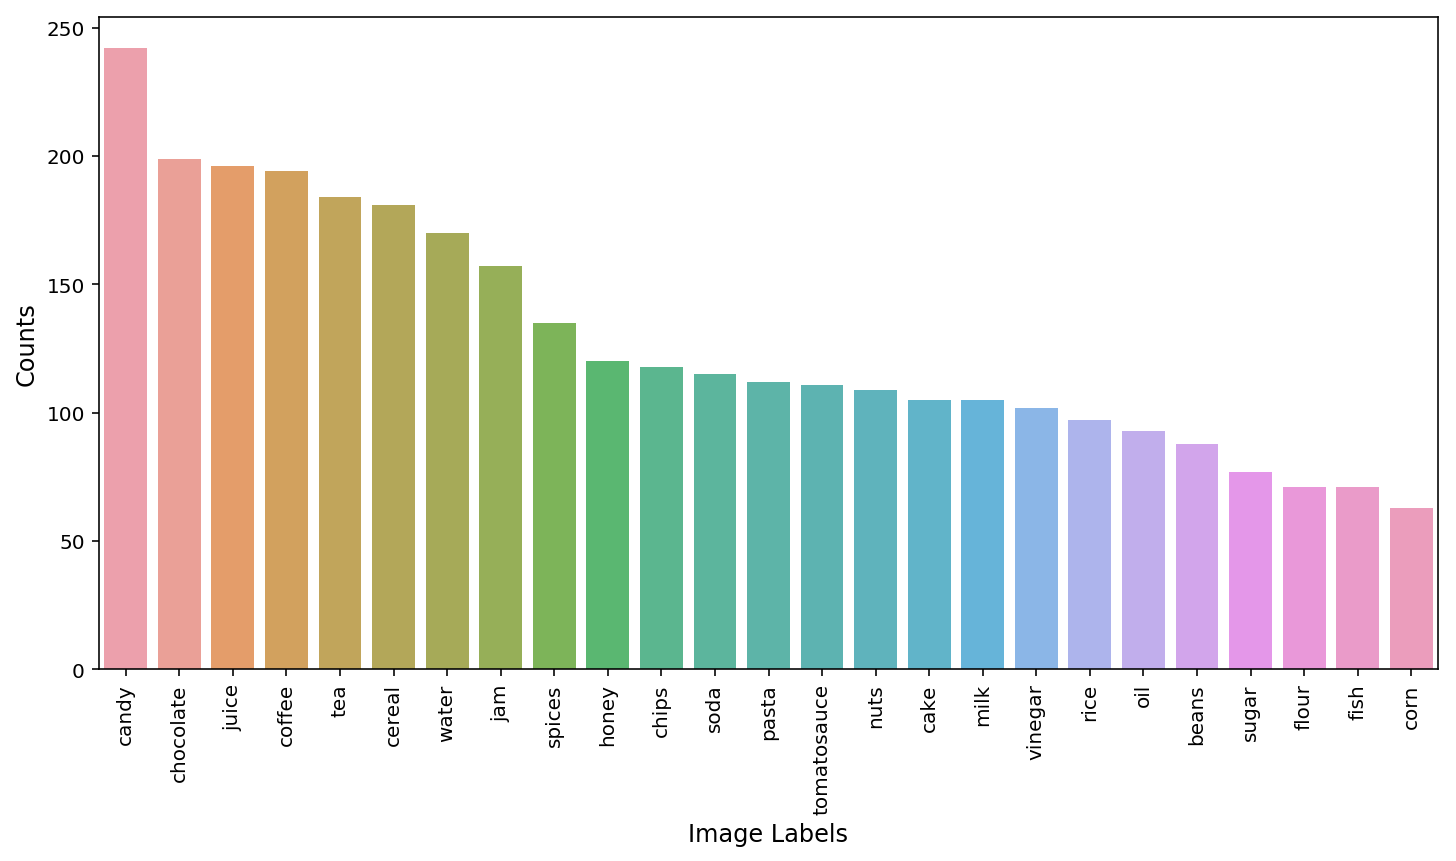

In [9]:
# lets see the distribution
label_counts = train_labels_df['label'].value_counts()

plt.figure(figsize = (12,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)
plt.xticks(rotation = 'vertical')
plt.xlabel('Image Labels', fontsize =12)
plt.ylabel('Counts', fontsize = 12);

Clearly some classes are underrepresented as compared to others. So when we split the data into train and validation sets we have to do stratified splitting.

## 1. Visualizing a few Training Images (using scikit-image)

In [10]:
## set path for images
TRAIN_IMG_PATH = 'data/train_img/'
TEST_IMG_PATH = 'data/test_img/'

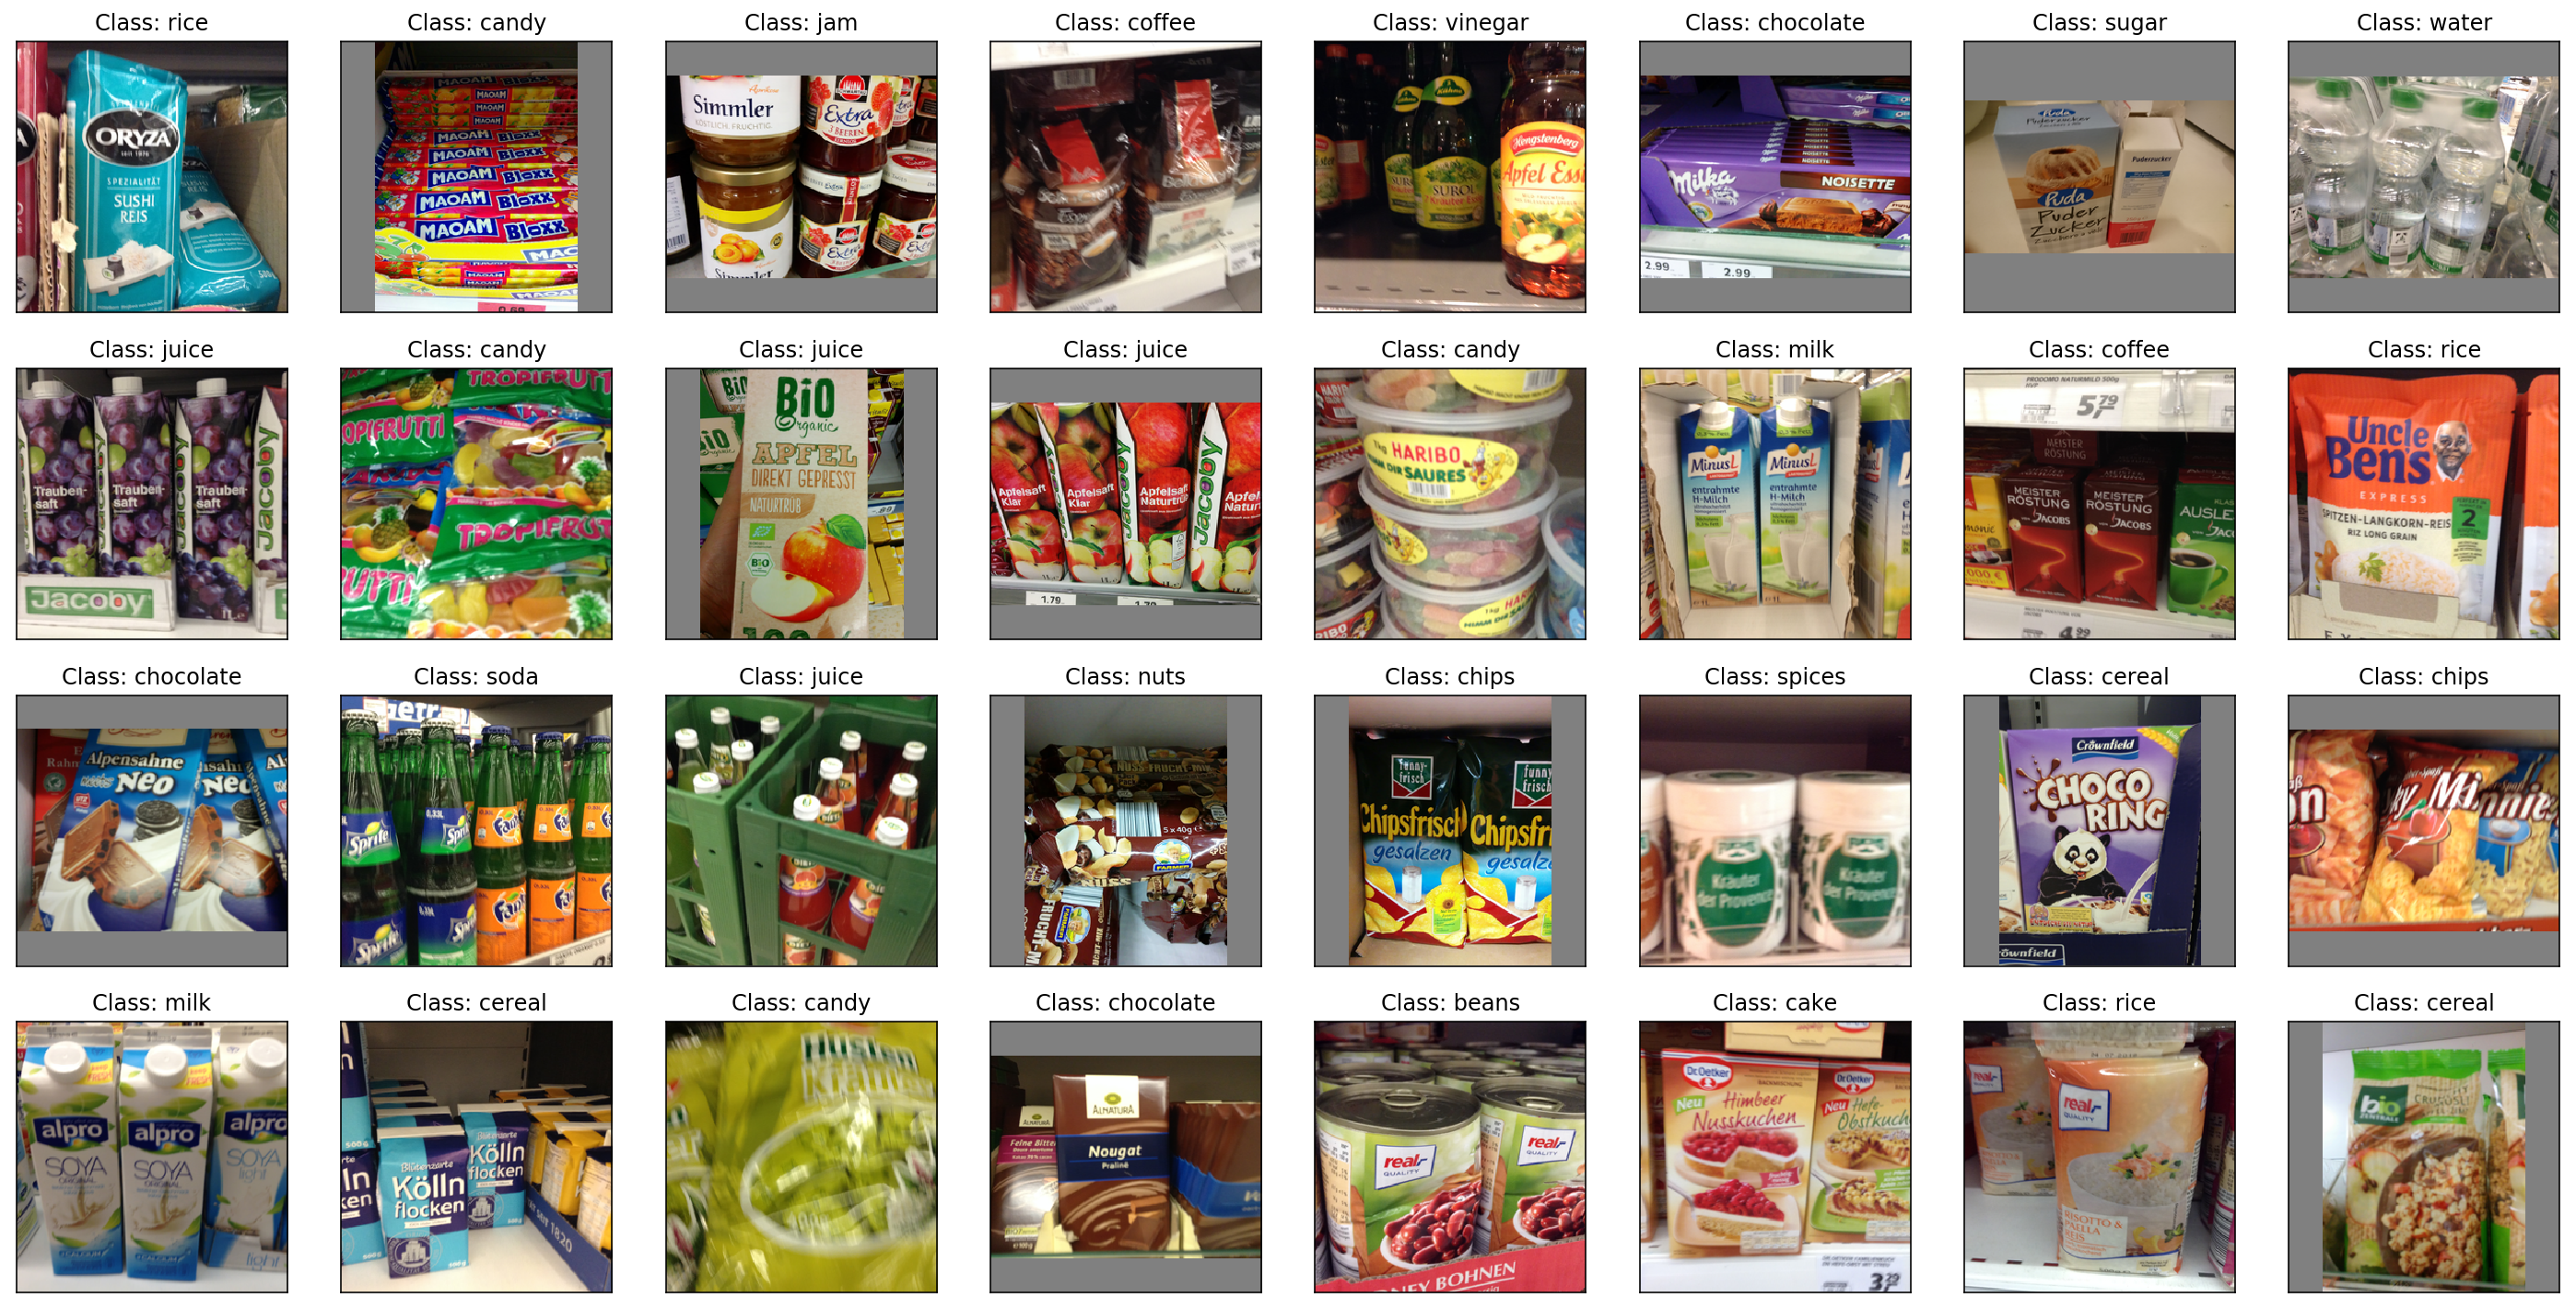

In [11]:
import skimage.io
import skimage.transform

fig = plt.figure(figsize=(20, 10))
nrows, ncols = 4, 8
for i, row in enumerate(train_labels_df.head(nrows * ncols).itertuples(index=False)):
    ax = fig.add_subplot(nrows, ncols, i + 1, xticks=[], yticks=[])
    img_path, img_label = TRAIN_IMG_PATH + row[0] + '.png', row[1]
    skimage.io.imshow(skimage.transform.resize(skimage.io.imread(img_path), (256, 256), mode='reflect'))
    ax.set_title('Class: {0}'.format(img_label))

## 2. Visualizing a few Testing Images (using opencv)

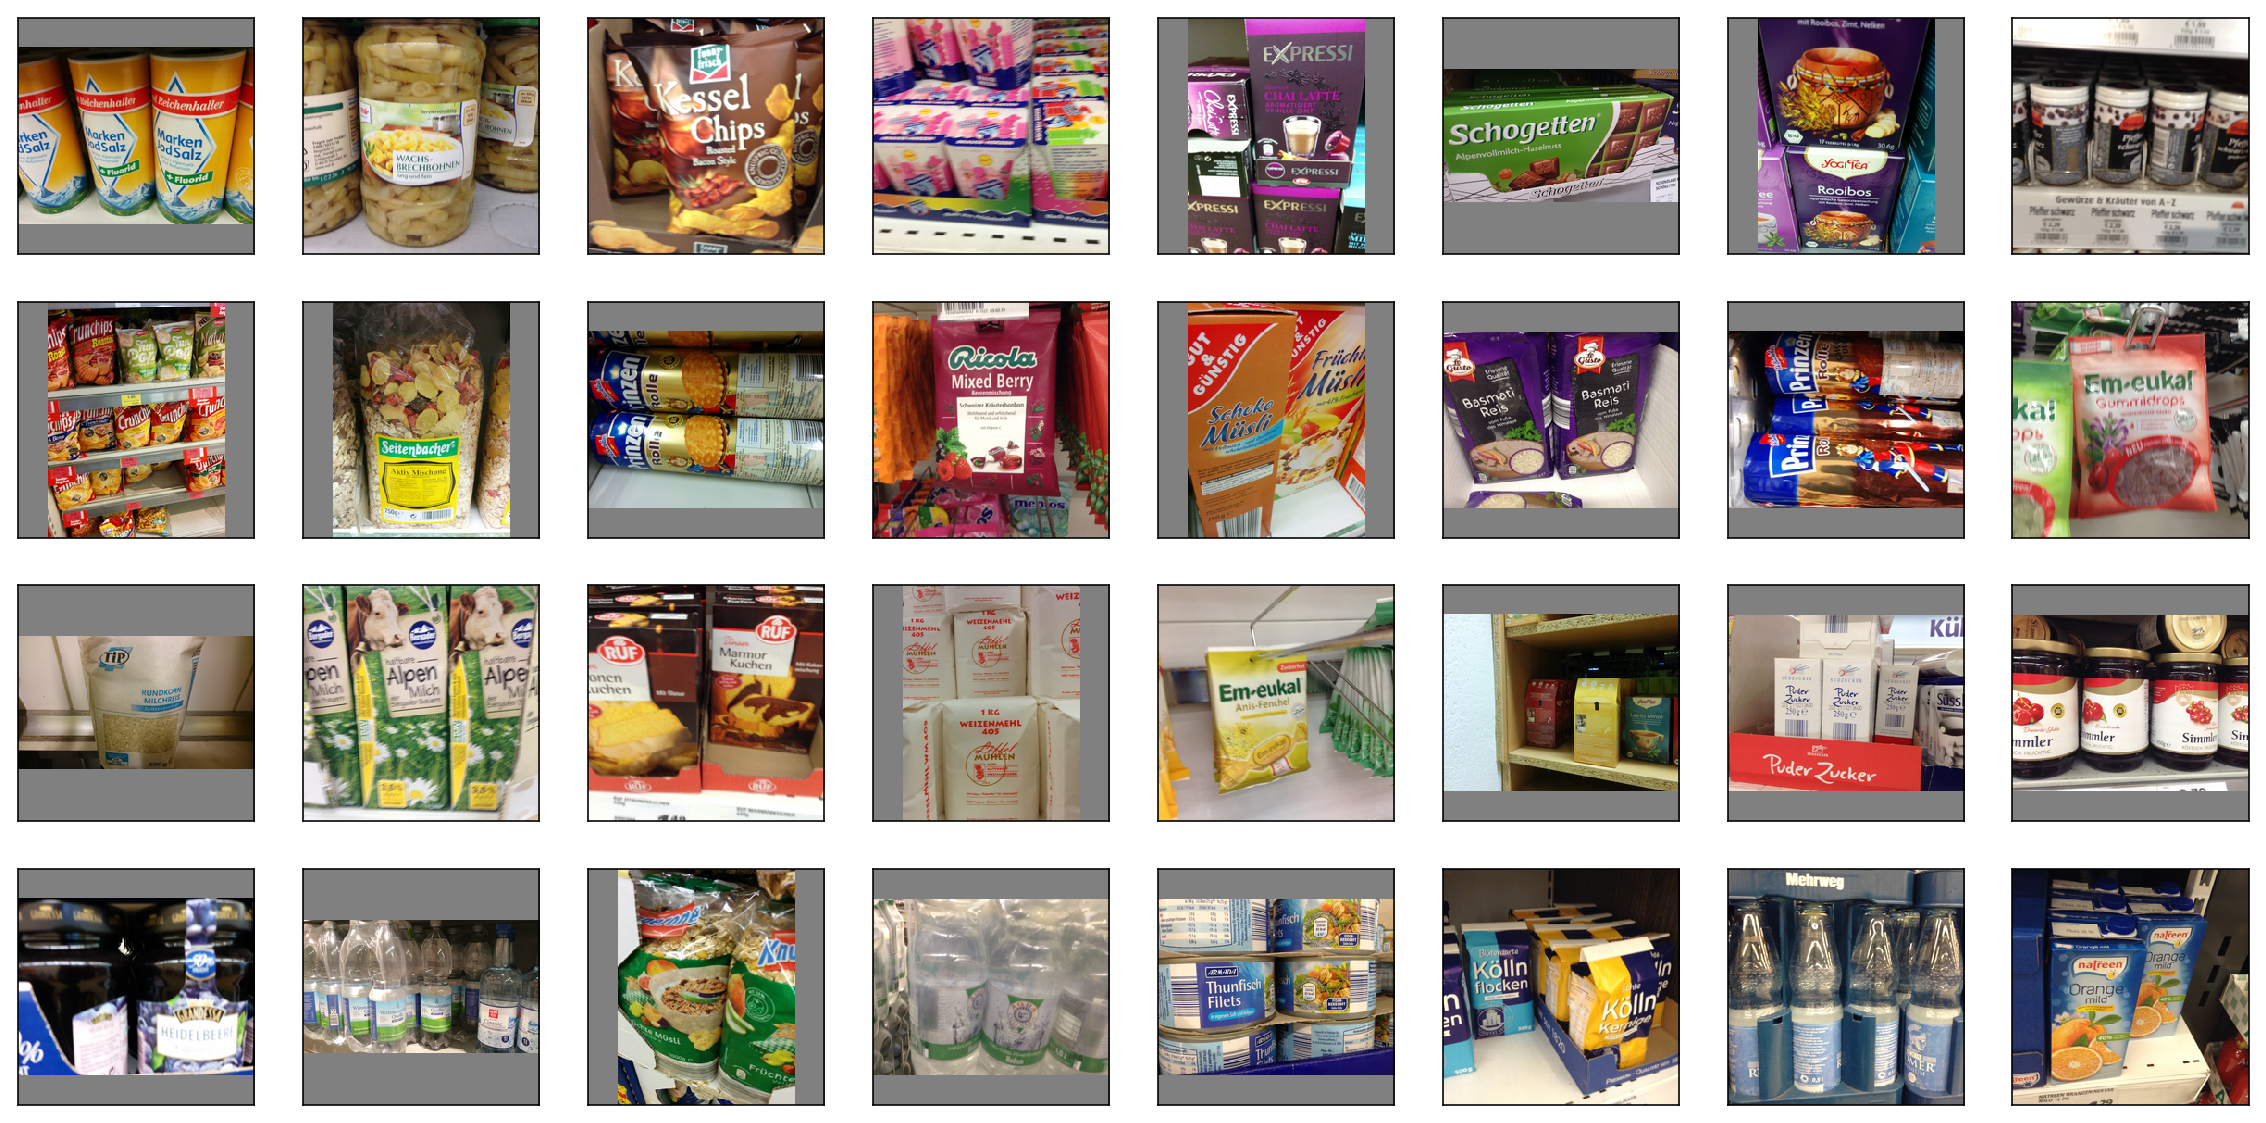

In [12]:
import cv2
fig = plt.figure(figsize=(20, 10))
nrows, ncols = 4, 8
for i, row in enumerate(test_labels_df.sample(nrows * ncols).itertuples(index=False)):
    ax = fig.add_subplot(nrows, ncols, i + 1, xticks=[], yticks=[])
    img_path = TEST_IMG_PATH + row[0] + '.png'
    img = cv2.imread(img_path)
    ax.imshow(cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (256, 256)))

## 3. Split data into train and valid sets

In [13]:
# pick random images to be split into train and valid sets but stratified sampled per product category
from sklearn.model_selection import train_test_split
train_labels_df, valid_labels_df = train_test_split(train_labels_df, test_size=0.33, stratify=train_labels_df['label'], random_state=seed)

In [14]:
train_labels_df.shape, valid_labels_df.shape

((2154, 2), (1061, 2))

## 4. Create Keras ImageGenerator compatible directory structure

In [15]:
KERAS_DATAGEN_TRAIN_IMG_PATH = 'data_gen/train/'
KERAS_DATAGEN_VALID_IMG_PATH = 'data_gen/valid/'
KERAS_DATAGEN_TEST_IMG_PATH = 'data_gen/test/'

In [16]:
# make training directory structure
print('Creating Training and Validation Directory Structure')
for label in train_labels_df['label'].unique():
    pathlib.Path(KERAS_DATAGEN_TRAIN_IMG_PATH + label).mkdir(parents=True, exist_ok=True)
    pathlib.Path(KERAS_DATAGEN_VALID_IMG_PATH + label).mkdir(parents=True, exist_ok=True)

Creating Training and Validation Directory Structure


In [17]:
# make testing directory structure
print('Creating Test Directory Structure')
pathlib.Path(KERAS_DATAGEN_TEST_IMG_PATH + 'unknown').mkdir(parents=True, exist_ok=True)

Creating Test Directory Structure


### 4.1 Copy images into respective directories for Keras ImageGenerator

In [20]:
# copy the training set files
print('Copying Training Images...')
for row in train_labels_df.itertuples(index=False):
    img_id, label = row[0], row[1]
    copyfile(TRAIN_IMG_PATH + img_id + '.png', KERAS_DATAGEN_TRAIN_IMG_PATH + label + '/' + img_id + '.png')

Copying Training Images...


In [21]:
# copy the validation set files
print('Copying Validation Images...')       
for row in valid_labels_df.itertuples(index=False):
    img_id, label = row[0], row[1]
    copyfile(TRAIN_IMG_PATH + img_id + '.png', KERAS_DATAGEN_VALID_IMG_PATH + label + '/' + img_id + '.png')

Copying Validation Images...


In [22]:
# copy the test set files
print('Copying Test Images...')    
for row in test_labels_df.itertuples(index=False):
    img_id = row[0]
    copyfile(TEST_IMG_PATH + img_id + '.png', KERAS_DATAGEN_TEST_IMG_PATH + 'unknown/' + img_id + '.png')

Copying Test Images...


In [23]:
print('Directory Structure Created!')

Directory Structure Created!
